In [13]:
from pathlib import Path
from openai import OpenAI
from tqdm import tqdm
from utils.pred_with_history import pipeline
from utils.api import get_response
from utils.io import json_data_to_df
from zoneinfo import ZoneInfo
from datetime import datetime

import json
import time
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [8]:
inv_type = "banks"
data_name = inv_type + ".json"
df = json_data_to_df(data_name)
mgrno = 7800
permno = 10107
start_date = "2010-04-01"
end_date = "2019-07-01"
call_fn = get_response
investor_role = inv_type

In [ ]:

def build_aum_panel(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")

    
    panel = (d.groupby(["mgrno", "fdate"], as_index=False)
               .agg(aum=("aum", "first"),
                    n_rows=("aum", "size"),
                    n_aum_uniq=("aum", "nunique")))

    
    bad = panel.query("n_aum_uniq > 1")
    if not bad.empty:
        print("[WARN]")
        print(bad.sort_values(["mgrno","fdate"]).head(10))

    
    return panel[["mgrno", "fdate", "aum"]].sort_values(["mgrno","fdate"])



def aum_timeseries_for(df_panel: pd.DataFrame, mgr: int) -> pd.DataFrame:
    sub = (df_panel[df_panel["mgrno"] == mgr]
           .sort_values("fdate")
           .reset_index(drop=True))
    # QoQ / YoY
    sub["aum_qoq"] = sub["aum"].pct_change(1)     
    sub["aum_yoy"] = sub["aum"].pct_change(4)     
    return sub


def plot_aum_ts(sub: pd.DataFrame, title: str = None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    if sub.empty:
        print("Empty Data")
        return
    title = title or f"AUM over time - mgrno {int(sub['mgrno'].iat[0])}"
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.plot(sub["fdate"], sub["aum"], marker="o")
    ax.set_title(title)
    ax.set_xlabel("Date"); ax.set_ylabel("AUM")
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

def build_aum_decomp_panel(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")

    g = (d.groupby(["mgrno","fdate"], as_index=False)
           .agg(aum=("aum","first"),
                holding_sum=("holding","sum"),
                outaum_first=("outaum","first"),
                outaum_nuniq=("outaum","nunique")))

    outaum_from_mass = g["aum"] - g["holding_sum"]
    g["outaum_use"] = np.where(g["outaum_nuniq"].eq(1), g["outaum_first"], outaum_from_mass)

    g["closure_err"] = g["aum"] - (g["holding_sum"] + g["outaum_use"])

    return g[["mgrno","fdate","aum","holding_sum","outaum_use","closure_err"]].sort_values(["mgrno","fdate"])

def plot_aum_decomp(panel: pd.DataFrame, mgr: int, title: str|None=None):
    sub = panel[panel["mgrno"]==mgr].sort_values("fdate")
    if sub.empty:
        print(f"mgrno={mgr} Empty Data"); return None, None

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sub["fdate"], sub["aum"],          marker="o", label="AUM")
    ax.plot(sub["fdate"], sub["holding_sum"],  marker="o", label="Σ Holdings")
    ax.plot(sub["fdate"], sub["outaum_use"],   marker="o", label="OutAUM")

    ax.set_title(title or f"AUM decomposition over time  (mgrno={mgr})")
    ax.set_xlabel("Date"); ax.set_ylabel("Amount")
    ax.grid(True); ax.legend()

    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate(); fig.tight_layout()

    print(sub["closure_err"].describe())
    return fig, ax

count    4.000000e+01
mean    -3.707100e-10
std      1.113388e-09
min     -2.197339e-09
25%     -1.196895e-09
50%     -3.929017e-10
75%      4.947651e-10
max      2.313755e-09
Name: closure_err, dtype: float64


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'AUM decomposition over time  (mgrno=7800)'}, xlabel='Date', ylabel='Amount'>)

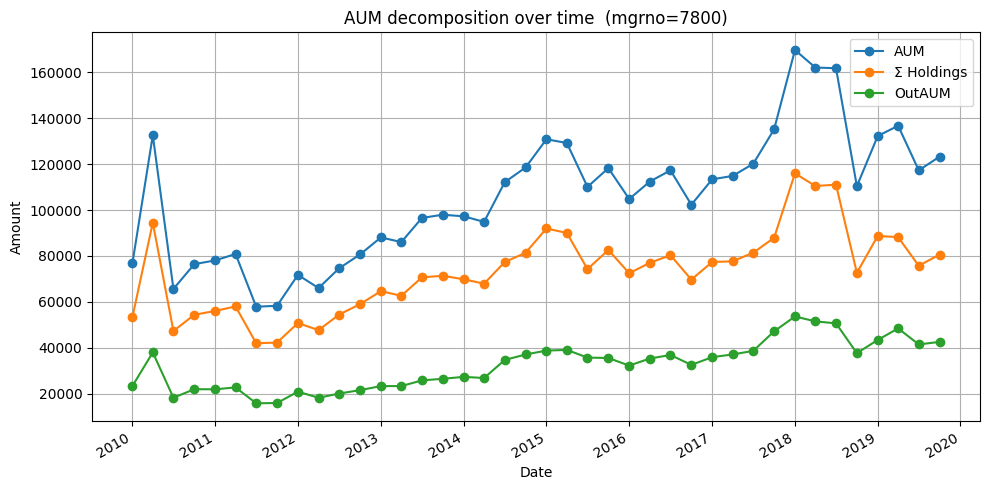

In [ ]:

panel = build_aum_decomp_panel(df)

plot_aum_decomp(panel, mgr=7800)

In [16]:
def _group_mass(df):
    """(mgrno,fdate) 聚合：AUM, Hsum, outaum_use, r=outweight"""
    d = df.copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")
    g = (d.groupby(["mgrno","fdate"], as_index=False)
           .agg(AUM=("aum","first"),
                Hsum=("holding","sum"),
                outaum_first=("outaum","first"),
                outaum_nuniq=("outaum","nunique")))
    outaum_use = np.where(g["outaum_nuniq"].eq(1), g["outaum_first"], g["AUM"] - g["Hsum"])
    g["r"] = (outaum_use / g["AUM"]).clip(0, 0.9999)
    g = g.sort_values(["mgrno","fdate"]).reset_index(drop=True)
    return g[["mgrno","fdate","AUM","Hsum","r"]]

def _shift_next(df):
    """构造 t 与 t+1 对齐的面板：A_t, Hsum_{t+1}, A_{t+1}, r_t"""
    df = df.sort_values(["mgrno","fdate"])
    df["A_next"]    = df.groupby("mgrno")["AUM"].shift(-1)
    df["Hsum_next"] = df.groupby("mgrno")["Hsum"].shift(-1)
    df["r_prev"]    = df.groupby("mgrno")["r"].shift(0)      # r_t
    df["r_last4"]   = df.groupby("mgrno")["r"].transform(lambda s: s.rolling(4, min_periods=1).median()).shift(1)  # 4季滚动中位到 t+1
    df["r_ema"]     = df.groupby("mgrno")["r"].transform(lambda s: s.ewm(alpha=0.3, adjust=False).mean()).shift(1) # EMA 到 t+1
    df["r_mgr_fix"] = df.groupby("mgrno")["r"].transform("median").shift(1)  # 经理人固定中位到 t+1
    df = df.dropna(subset=["A_next","Hsum_next","r_prev"])   # 要有 t 和 t+1
    return df

def _eval_variant(name, rhat, A_next, Hsum_next):
    Ahat = Hsum_next / (1 - rhat).replace(0, np.nan)
    rel_err = (Ahat - A_next) / A_next.replace(0, np.nan)
    out = pd.DataFrame({
        "variant": name,
        "Ahat": Ahat, "A_next": A_next, "rel_err": rel_err.abs()
    })
    return out

def backtest_outweight_approx(df_hist):
    g = _group_mass(df_hist)
    panel = _shift_next(g)

    variants = {
        "r_t"       : panel["r_prev"],    # 直接用 r_t 近似 r_{t+1}
        "roll4_med" : panel["r_last4"],   # 用过去4季中位
        "ema_0.3"   : panel["r_ema"],     # EMA(alpha=0.3)
        "mgr_fix"   : panel["r_mgr_fix"], # 经理人固定中位
    }

    outs = []
    for name, rhat in variants.items():
        o = _eval_variant(name, rhat, panel["A_next"], panel["Hsum_next"])
        o["mgrno"] = panel["mgrno"].values
        o["fdate"] = panel["fdate"].values
        outs.append(o)

    res = pd.concat(outs, ignore_index=True)

    # 总体指标
    summ = (res.groupby("variant")
              .agg(count=("rel_err","size"),
                   mape=("rel_err","mean"),
                   med_ape=("rel_err","median"),
                   p90=("rel_err", lambda s: s.quantile(0.90)),
                   within_2=("rel_err", lambda s: (s <= 0.02).mean()),
                   within_5=("rel_err", lambda s: (s <= 0.05).mean()),
                   within_10=("rel_err", lambda s: (s <= 0.10).mean()))
              .sort_values("mape"))
    return res, summ

In [17]:
res, summ = backtest_outweight_approx(df)  # 这里把 df 传进去即可
print(summ.head())

           count      mape   med_ape       p90  within_2  within_5  within_10
variant                                                                      
r_t         6670  0.033144  0.012205  0.052273  0.677061  0.893253   0.956072
ema_0.3     6670  0.056496  0.024858  0.099705  0.422189  0.750225   0.900450
roll4_med   6670  0.060205  0.024559  0.099565  0.430135  0.757721   0.900750
mgr_fix     6670  0.069214  0.026521  0.106366  0.411544  0.709145   0.888756


In [ ]:
def _agg(df):
    
    d = df.copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")
    g = (d.groupby(["mgrno","fdate"], as_index=False)
           .agg(AUM=("aum","first"),
                Hsum=("holding","sum"),
                outaum_first=("outaum","first"),
                outaum_nuniq=("outaum","nunique")))
    outaum = np.where(g["outaum_nuniq"].eq(1), g["outaum_first"], g["AUM"]-g["Hsum"])
    outaum = np.clip(outaum, 0, None)
    g["OutAUM"] = outaum
    g["r"] = (outaum / g["AUM"]).clip(0, 0.9999)
    g = g.sort_values(["mgrno","fdate"]).reset_index(drop=True)
    return g[["mgrno","fdate","AUM","Hsum","OutAUM","r"]]

def _panel(df):
    
    g = _agg(df).sort_values(["mgrno","fdate"])
    g["A_next"]    = g.groupby("mgrno")["AUM"].shift(-1)
    g["Hsum_next"] = g.groupby("mgrno")["Hsum"].shift(-1)
    g["r_t"]       = g.groupby("mgrno")["r"].shift(0)
    g["OA_t"]      = g.groupby("mgrno")["OutAUM"].shift(0)
   
    g["OA_ema"]    = (g.groupby("mgrno")["OutAUM"]
                        .transform(lambda s: s.ewm(alpha=0.3, adjust=False).mean())
                        .shift(1))
    g["OA_roll4"]  = (g.groupby("mgrno")["OutAUM"]
                        .transform(lambda s: s.rolling(4, min_periods=1).median())
                        .shift(1))
    g["r_ema"]   = (g.groupby("mgrno")["r"]
                  .transform(lambda s: s.ewm(alpha=0.3, adjust=False).mean())
                  .shift(1))
    g["r_roll4"] = (g.groupby("mgrno")["r"]
                    .transform(lambda s: s.rolling(4, min_periods=1).median())
                    .shift(1))
    g = g.dropna(subset=["A_next","Hsum_next","r_t","OA_t"])
    return g

def _summ(df_err, name):
    
    if "Ahat" in df_err:
        ape = ( (df_err["Ahat"] - df_err["A_next"]).abs()
                / df_err["A_next"].replace(0, np.nan) ).dropna()
    else:
        
        ape = ( df_err["abs_err"].abs()
                / df_err["A_next"].replace(0, np.nan) ).dropna()
    return pd.Series({
        "variant":  name,
        "count":    int(ape.size),
        "mape":     float(ape.mean()),
        "med_ape":  float(ape.median()),
        "p90":      float(ape.quantile(0.90)),
        "within_2": float((ape <= 0.02).mean()),
        "within_5": float((ape <= 0.05).mean()),
        "within_10":float((ape <= 0.10).mean()),
    })

def compare_R_vs_O(df):
    P = _panel(df)  
                    

    rows = []

    
    for nm, rcol in [("R: r_t", "r_t"),
                     ("R: r_ema", "r_ema"),
                     ("R: r_roll4", "r_roll4")]:
        if rcol in P.columns:
            rhat = P[rcol].clip(0, 0.98)                      
            denom = (1 - rhat).replace(0, np.nan)            
            Ahat  = P["Hsum_next"] / denom
            df_err = pd.DataFrame({"A_next": P["A_next"], "Ahat": Ahat}).dropna()
            rows.append(_summ(df_err, nm))

    
    for nm, ocol in [("O: OA_t", "OA_t"),
                     ("O: OA_ema", "OA_ema"),
                     ("O: OA_roll4", "OA_roll4")]:
        if ocol in P.columns:
            Ahat  = P["Hsum_next"] + P[ocol]
            df_err = pd.DataFrame({"A_next": P["A_next"], "Ahat": Ahat}).dropna()
            rows.append(_summ(df_err, nm))

    res = pd.DataFrame(rows).set_index("variant").sort_values("mape")
    return res

In [23]:
result = compare_R_vs_O(df)
print(result)

             count      mape   med_ape       p90  within_2  within_5  \
variant                                                                
R: r_t        6670  0.033144  0.012205  0.052273  0.677061  0.893253   
O: OA_t       6670  0.037618  0.016931  0.062750  0.562669  0.859970   
R: r_ema      6670  0.056496  0.024858  0.099705  0.422189  0.750225   
R: r_roll4    6670  0.060205  0.024559  0.099565  0.430135  0.757721   
O: OA_ema     6670  1.102583  0.036572  0.129097  0.289505  0.640630   
O: OA_roll4   6670  1.103635  0.033596  0.125515  0.320540  0.668366   

             within_10  
variant                 
R: r_t        0.956072  
O: OA_t       0.952474  
R: r_ema      0.900450  
R: r_roll4    0.900750  
O: OA_ema     0.864918  
O: OA_roll4   0.868216  


In [26]:
def plot_true_r_multi(df: pd.DataFrame, mgrnos, save_path=None):
    """
    直接口径: r_t = outaum_t / aum_t
    在同一张图里对比多个 mgrno 的 r_t 时间序列。

    必需列: ['mgrno','fdate','aum','outaum']
    """
    # 标准化输入
    mgrnos = list(mgrnos)
    d = df.copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")

    fig, ax = plt.subplots(figsize=(9, 4.6))

    for m in mgrnos:
        x = d[d["mgrno"] == m].copy()
        if x.empty:
            print(f"[warn] mgrno={m} 没有数据，跳过。")
            continue

        # 粗检: 同一(季度、mgrno)下 AUM/OutAUM 是否唯一（若不唯一，median 会兜底）
        tmp = (x.groupby(["mgrno", "fdate"])
                 .agg(aum_nuni=("aum", "nunique"),
                      outaum_nuni=("outaum", "nunique"))
                 .reset_index())
        prob = tmp[(tmp["aum_nuni"] > 1) | (tmp["outaum_nuni"] > 1)]
        if not prob.empty:
            nprob = len(prob)
            print(f"[note] mgrno={m} 存在 {nprob} 个 (mgrno,fdate) 上的 AUM/OutAUM 多值；将用 median 聚合。")

        # 先到(日期, 机构)聚合：median 更稳健
        g = (x.groupby(["mgrno", "fdate"])
               .agg(A=("aum", "median"),
                    OA=("outaum", "median"))
               .reset_index())

        # 计算直接口径 r，并对齐到季度（再做一次季度层面的 median 保证唯一）
        g["r"] = g["OA"] / g["A"]
        g["q"] = g["fdate"].dt.to_period("Q")
        s = (g.groupby("q")["r"].median()
               .clip(0, 1)            # 裁剪到 [0,1]
               .dropna())

        if s.empty:
            print(f"[warn] mgrno={m} 无有效 r 值（可能缺列或为NaN），跳过。")
            continue

        ax.plot(s.index.to_timestamp(how="start"),
                s.values, marker="o", label=f"mgrno={m}")

    ax.set_title("True outweight r over time (direct: outaum/aum)")
    ax.set_xlabel("Quarter")
    ax.set_ylabel("r = OutAUM / AUM")
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend(ncol=2)
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved figure -> {save_path}")

    return fig, ax

def find_mgrnos_full_series(
    df: pd.DataFrame,
    require_cols=("aum", "outaum"),
    top_n: int = 5
):
    """
    从 df 中找出在整体季度时间轴上“每季都有记录”的 mgrno。
    若不足 top_n，则按覆盖率从高到低补齐到 top_n。

    返回：
    - mgr_list: 长度最多 top_n 的 mgrno 列表（优先全覆盖）
    - coverage: DataFrame，包含每个 mgrno 的覆盖统计（便于检查）
    - all_quarters: 全体季度 PeriodIndex
    """
    d = df.copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")
    d["q"] = d["fdate"].dt.to_period("Q")

    # 只保留需要列非空的行（直接口径 r=outaum/aum 需要两列）
    if require_cols:
        mask = d[list(require_cols)].notna().all(axis=1)
        d = d[mask]

    # 全体季度轴
    all_quarters = pd.Index(sorted(d["q"].dropna().unique()))

    # 每个 (mgrno, q) 是否出现
    pres = d.drop_duplicates(subset=["mgrno", "q"])[["mgrno", "q"]]

    # 统计覆盖
    cov = (pres.groupby("mgrno")["q"]
                .nunique()
                .rename("n_quarters")
                .to_frame())
    cov["total_quarters"] = len(all_quarters)
    cov["coverage_ratio"] = cov["n_quarters"] / cov["total_quarters"]

    # 先选“全覆盖”的
    full_mgrs = cov.index[cov["n_quarters"] == len(all_quarters)].tolist()

    # 如果不足 top_n，按覆盖率降序补齐
    if len(full_mgrs) < top_n:
        need = top_n - len(full_mgrs)
        extras = (cov[~cov.index.isin(full_mgrs)]
                  .sort_values(["coverage_ratio", "n_quarters", "mgrno"], ascending=[False, False, True])
                  .head(need)
                  .index
                  .tolist())
        mgr_list = full_mgrs + extras
    else:
        mgr_list = full_mgrs[:top_n]

    # 也返回明细覆盖表，便于查看
    coverage = cov.sort_values(["coverage_ratio", "n_quarters"], ascending=[False, False])
    return mgr_list, coverage, all_quarters

Saved figure -> outputs/r_multi.png


(<Figure size 900x460 with 1 Axes>,
 <Axes: title={'center': 'True outweight r over time (direct: outaum/aum)'}, xlabel='Quarter', ylabel='r = OutAUM / AUM'>)

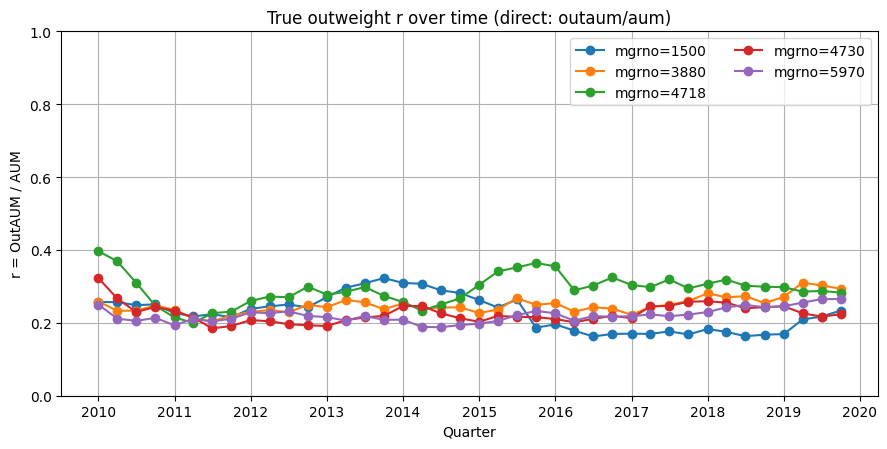

In [27]:

mgr_list, coverage, quarters = find_mgrnos_full_series(df, require_cols=("aum","outaum"), top_n=5)
plot_true_r_multi(df, mgrnos=mgr_list, save_path="outputs/r_multi.png")